### **INSTALL AND IMPORT REQUIRED PACKAGES**

In [1]:
!pip install cartopy biopython gpustat transformers datasets scikit-learn --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.1/98.1 kB 8.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 55.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.7/84.7 kB 6.7 MB/s eta 0:00:00


### **IMPORT REQUIRED PACKAGES**

In [2]:
import os
import json
import sys
import random
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from platform import python_version

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import transformers
from transformers import AutoTokenizer, AutoModel

from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
                             auc, roc_curve, precision_recall_curve,
                             confusion_matrix, ConfusionMatrixDisplay, classification_report
)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

print("Necessary packages installed and imported successfully!")
print("Python version", python_version())
print("Pytorch - version", torch.__version__)
print("Transfomer version: ", transformers.__version__)
print("Pytorch - cuDNN version :", torch.backends.cudnn.version())

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory // 1024**3} GB")

Necessary packages installed and imported successfully!
Python version 3.11.13
Pytorch - version 2.6.0+cu124
Transfomer version:  4.52.4
Pytorch - cuDNN version : 90300
Using device: cuda
GPU: Tesla T4
GPU Memory: 14 GB


### **SET RANDOM SEED**

In [3]:
def set_all_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_all_seeds(42)
print("All seeds set for reproducibility.")

All seeds set for reproducibility.


### **CUSTOM FUNCTION FOR CLEANINIG GPU MEMORY**

In [9]:
def clean_gpu():
    torch.cuda.empty_cache()
    gc.collect()

### **LOAD THE DATA**

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

WORKDIR = "/content/drive/MyDrive/Colab Notebooks/Seminar-AMR/"
DATA_DIR = os.path.join(WORKDIR, "data")
CODE_SOURCE_DIR = os.path.join(WORKDIR, "src")
GENE_OUTPUT_DIR = os.path.join(DATA_DIR, "genes")
RESULT_DIR = os.path.join(WORKDIR, "results")
sys.path.append(WORKDIR)

filename = os.path.join(RESULT_DIR, "balanced_data.csv")
df_all = pd.read_csv(filename)

df_train = df_all[df_all["split"] == "train"]
df_val   = df_all[df_all["split"] == "val"]
df_test  = df_all[df_all["split"] == "test"]

seq_train, y_train = df_train["sequence"].tolist(), df_train["label"].tolist()
seq_val, y_val     = df_val["sequence"].tolist(),   df_val["label"].tolist()
seq_test, y_test   = df_test["sequence"].tolist(),  df_test["label"].tolist()

print("Reloaded train/val/test splits from CSV")

Mounted at /content/drive/
Reloaded train/val/test splits from CSV


### **HANDLE TRAINING CLASS IMABALANCE (CLASS WEIGHTAGE)**

In [8]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)                               # Calculate class weights for imbalanced training data
pos_weight = torch.tensor(class_weights[1] / class_weights[0], dtype=torch.float32).to(device)                        # We give higher weightage to minority class and lower weightage to majority class during loss calculation. We will use this weight while defining loss function criteria.

print(f"Class weights: Non-Resistant={class_weights[0]:.3f}, Resistant={class_weights[1]:.3f}")
print(f"Positive weight for BCE loss: {pos_weight.item():.3f}")

Class weights: Non-Resistant=1.000, Resistant=1.000
Positive weight for BCE loss: 1.000


## **SECTION: BASELINE TRANSFORMER SETUP**

### **BUILDING CUSTOM VOCABULARY FROM TRAINING DATA**

In [10]:
def generate_kmers(sequence, k=6):
    """
    Convert a DNA sequence into overlapping k-mers (k=6 by default).
    For longer sequences, creates sliding windows: "ATCGATC" → ["ATCGAT", "TCGATC"].
    Returns a list of k-mers.
    """
    return [sequence[i:i+k] for i in range(len(sequence) - k + 1)]


def extract_all_kmers(sequences, k=6):
    """
    Processes multiple DNA sequences to extract all k-mers. For each sequence, it calls generate_kmers() to get k-mers.
    Tracks the maximum sequence length (in k-mers) for padding purposes.
    Returns all k-mers (with repetitions, if any) and the longest sequence length.
    """
    all_kmers = []
    max_seq_length_kmers = 0
    for seq in sequences:
        kmers = generate_kmers(seq.upper(), k)
        all_kmers.extend(kmers)
        if len(kmers) > max_seq_length_kmers:
            max_seq_length_kmers = len(kmers)

    return all_kmers, max_seq_length_kmers

"""
Vocab: A dictionary that maps each unique k-mer to a unique integer ID.
Token ID: An integer ID representing the index of the k-mer in the vocabulary.
"""
# Build vocabulary from training data
k = 6
print(f"Building k-mer vocabulary (k={k})...")
all_kmers, max_seq_length_kmers = extract_all_kmers(seq_train, k)                     # Extract k-mers from training data only (to prevent data leakage)
kmer_counts = Counter(all_kmers)                                                      # Count unique k-mers
unique_kmers = sorted(kmer_counts.keys())
vocab = {'<pad>': 0, '<unk>': 1}                                                      # Add special tokens: <pad>: 0 is used to pad shorter sequences in a batch to match the length of the longest sequence. <unk>: 1 represents words or phrases that are not in the vocabulary.
vocab.update({kmer: idx + 2 for idx, kmer in enumerate(unique_kmers)})                # Build vocab consisting of two special tokens and the extracted unique k-mers. We are only interested in different unique k-mers, not their frequency.


inv_vocab = {idx: kmer for kmer, idx in vocab.items()}                                # Inverse mapping for decoding (optional)

print(f"Total k-mers (with duplicates): {sum(kmer_counts.values()):,}")
print(f"Unique k-mers: {len(unique_kmers):,}")
print(f"Final vocab size (including <pad> and <unk>): {len(vocab):,}")
print("Custom vocabulary built successfully!")

Building k-mer vocabulary (k=6)...
Total k-mers (with duplicates): 201,396
Unique k-mers: 1,946
Final vocab size (including <pad> and <unk>): 1,948
Custom vocabulary built successfully!


### **COMPUTING POSITION EMBEDDING SIZE**

In [11]:
position_embedding_size = max_seq_length_kmers + 1 + 10                               # The +1 is for the index 0, plus the max length, plus a buffer of 10.

"""
Note: torch.nn.utils.pad_sequence() ensures all sequences are padded to the length of the longest in the batch. This is called inside the collate_fn() function. collate_fn() is used while creating the DataLoader.

The max_len for the positional embedding (passed as a parameter while creating an instance of the model) should be at least the max possible padded length, which is determined by the longest sequence in the *entire dataset* after k-mer conversion.
So, max_seq_length_kmers is the *unpadded* max length in the dataset. The padded length in a batch could be up to max_seq_length_kmers.
So the positional embedding size needs to be max_seq_length_kmers + 1 (for index 0 up to max_seq_length_kmers).

+ 10 is added as a safety buffer for potentially longer sequences during inference.
"""

print(f"Maximum sequence length (k-mers) found: {max_seq_length_kmers}")
print(f"Using positional embedding size: {position_embedding_size}")

Maximum sequence length (k-mers) found: 1291
Using positional embedding size: 1302


### **CUSTOM DATASET CLASS AND DATALOADER SETUP (USING OUR CUSTOM VOCAB)**

In [12]:
class CustomDNADataset(Dataset):
    """
    Inherits from PyTorch's torch.utils.data.Dataset class for data loading.
    Example usage:
        dataset = CustomDNADataset(sequences, labels, vocab, k=6)
        sample = dataset[0] --> __getitem__() is called internally. This returns a dictionary with keys: "input_ids" (Token IDs) and "labels". sample["input_ids"] will give you the token ids for the first DNA sequence and sample["labels"] will give you the corresponding label.
        len(dataset) --> __len__() is called internally. This returns the total number of DNA sequences in the dataset.
    """

    def __init__(self, sequences, labels, vocab, k=6):
        self.sequences = sequences
        self.labels = labels
        self.vocab = vocab
        self.k = k

    def __len__(self):
        """
        Returns the total number of DNA sequences in the dataset. Called by len(dataset).
        """

        return len(self.sequences)

    def __getitem__(self, idx):
        """
        This function is called automatically by PyTorch's DataLoader when it needs to fetch individual samples from the dataset.
        This function converts DNA sequence to k-mers, then to token IDs. This includes duplicates, i.e., if a k-mer appears multiple times, same token ID is assigned each time.
        For example: If the k-mers extracted from the DNA sequence is: ['ATCGGA', 'CGGTAC', 'GTTACG', 'ATCGGA', 'AAGCTA'], then the token ID will be assigned as: [4 1023 110 4 90] (Token IDs are shown randomly for illustrations).

        Uses generate_kmers() to extract k-mers.
        Uses vocab.get(kmer, vocab["<unk>"]) to convert k-mers to token IDs. Any k-mer not in the vocab is assigned the <unk> token ID.

        Returns dictionary with input_ids (tokenized sequence) and labels
        """

        seq = self.sequences[idx].upper()
        label = self.labels[idx]

        kmers = generate_kmers(seq, self.k)                                                          # Generate k-mers for the specific sequence
        token_ids = [self.vocab.get(kmer, self.vocab["<unk>"]) for kmer in kmers]                    # Convert k-mers to token IDs (Using the custom vocab). If the k-mer is not found (was not present in the training data, so not part of the voacb) - it returns the <unk> token ID (=1).

        return {
            "input_ids": torch.tensor(token_ids, dtype=torch.long),
            "labels": torch.tensor(label, dtype=torch.long)
        }

def collate_fn(batch):
    """
    Custom collate function for padding sequences
    Custom function to handle variable-length sequences in batches by padding them. collate_fn() is used while creating the DataLoader.
    torch.nn.utils.pad_sequence() ensures all sequences are padded to the length of the longest in the batch. It pads shorter sequences with <pad> token (ID=0), so that all sequences in batch become same length (length of longest sequence).
    batch_first=True ensures shape: [batch_size, sequence_length]
    """

    input_ids = [item["input_ids"] for item in batch]
    labels = [item["labels"] for item in batch]

    input_ids_padded = pad_sequence(input_ids, batch_first=True, padding_value=0)                    # Pad sequences to same length with <pad> token ID (which is 0) and return a single tensor for input sequences in the batch
    labels = torch.stack(labels)                                                                     # Stacks individual label tensors into a single batch tensor.

    return {
        "input_ids": input_ids_padded,
        "labels": labels
    }

# Create datasets for train / validation / test using the CustomDNADataset class
train_dataset = CustomDNADataset(seq_train, y_train, vocab, k=6)
val_dataset = CustomDNADataset(seq_val, y_val, vocab, k=6)
test_dataset = CustomDNADataset(seq_test, y_test, vocab, k=6)

# Create DataLoaders for each of the train / validation / test dataset.
# We use a batch_size = 2. This means, 2 training samples will be processed in a single iteration before the model's weights are updated.
batch_size = 2
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

print(f"Datasets created - Train: {len(train_dataset)}, Validation: {len(val_dataset)}, Test: {len(test_dataset)}")
print(f"DataLoaders ready with batch size: {batch_size}")

# Test the data loader
sample_batch = next(iter(train_loader))
print(f"Sample batch - Input shape: {sample_batch['input_ids'].shape}, Labels shape: {sample_batch['labels'].shape}")

Datasets created - Train: 156, Validation: 40, Test: 15
DataLoaders ready with batch size: 2
Sample batch - Input shape: torch.Size([2, 1291]), Labels shape: torch.Size([2])


### **CUSTOM BASELINE TRANSFORMER MODEL**

In [13]:
import torch.nn.functional as F

class RegularizedTransformer(nn.Module):
    def __init__(self, vocab_size, embed_dim=64, num_heads=2, num_layers=1, ff_dim=64, num_classes=1, dropout=0.3, max_len = 1500, use_cls_token=True):
        """
        embed_dim:      Dimensionality of token representations (Each k-mer ID (token) gets converted to a 128-dimensional vector)
        num_heads:      Number of attention heads in multi-head attention
        num_layers:     Number of transformer encoder layers stacked on top of each other
        ff_dim:         Hidden dimension of the feed-forward network inside each transformer layer
        dropout:        Dropout rate
        max_len:        Maximum sequence length for positional embedding
        """
        super(RegularizedTransformer, self).__init__()

        self.use_cls_token = use_cls_token

        # Token + Positional embeddings
        """
        Token Embedding:    "WHAT is at each position?" --> Converts each k-mer ID (token) into a dense 64-dimensional vector. E.g., token_emb[2] = [0.1, -0.3, 0.8, ...]  --> 64-dim vector for k-mer ID 2. padding_idx=0 ensures padding tokens have zero gradients i.e., no embedding.
        Position Embedding: "WHERE is each token in the sequence?" --> Helps the transformer understand the order/position of k-mers in the sequence. Unlike RNNs, transformers process all positions simultaneously and need explicit positional information.
                            It converts each position index into a 64-dimensional vector. E.g., pos_emb[2] = [0.1, -0.3, 0.8, ...]  --> 64-dim vector for position 2.

        In __init__(), we are only creating embedding tables (happen once during model initialization). These are just lookup tables - no computation happens yet!
        """
        if use_cls_token:
            # Reserve extra ID for CLS token
            self.cls_token_id = vocab_size
            self.token_embedding = nn.Embedding(vocab_size + 1, embed_dim, padding_idx=0)
        else:
            self.token_embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)                       # Token embedding table: [vocab_size, embed_dim]

        self.position_embedding = nn.Embedding(max_len, embed_dim)                                          # Position embedding table: [max_len, embed_dim]
        # Creates a lookup table with max_len rows and embed_dim columns.
        # Each row is a learnable 128-dimensional vector for a specific position.
        # max_len = position_embedding_size means we can handle sequences up to position (position_embedding_size - 1)

        self.input_dropout = nn.Dropout(dropout)                                                            # Dropout to the input embeddings (token + position) for regularization

        # PyTorch's TransformEncoderLayer implicitly implements Layer Normalization & Residual Connection
        encoder_layer = nn.TransformerEncoderLayer(                                                         # Generates a single transformer encoder layer with 4 multi-head self-attention, Feed-forward network (128 → 256 → 128), Embedding dimension = 128
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=ff_dim,
            dropout=dropout,
            activation='gelu',                                                                             # Gaussian Error Linear Units
            batch_first=True,                                                                              # Ensures the input shape is [batch_size, seq_length, embed_dim] instead of [seq_length, batch_size, embed_dim]
            norm_first=True                                                                                # Pre-norm for better training stability
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)             # Stacks multiple encoder layers (2 layers in this case)

        # Classification head with more dropout
        self.layer_norm = nn.LayerNorm(embed_dim)
        self.dropout1 = nn.Dropout(dropout*1.5)
        # self.fc1 = nn.Linear(embed_dim, embed_dim // 2)
        # self.activation = nn.ReLU()
        # self.dropout2 = nn.Dropout(dropout)
        # self.classifier = nn.Linear(embed_dim // 2, num_classes)

        self.classifier = nn.Linear(embed_dim, num_classes)                                                # Simpler version of Classification Head

        self._init_weights()                                                                               # Initialize weights

        # Store features before final classification for margin loss
        # self.return_features = False                                                                       # Flag to return intermediate features

    def _init_weights(self):
        """
        Initialize model weights
        """
        # Xavier/He initialization for better training
        # nn.init.xavier_uniform_(self.fc1.weight)
        # nn.init.xavier_uniform_(self.classifier.weight)
        # nn.init.zeros_(self.fc1.bias)
        # nn.init.zeros_(self.classifier.bias)
        for name, param in self.named_parameters():
            if 'weight' in name and param.dim() > 1:
                # Use 'relu' gain as an approximation for 'gelu'
                nn.init.xavier_uniform_(param, gain=nn.init.calculate_gain('relu'))
            elif 'bias' in name:
                nn.init.zeros_(param)

    def forward(self, input_ids, return_features=False):
        """
        Receives the Token IDs during training, process them and converts them to logits. Token IDs --> Logits.It handles tokenization, pooling, classification.
        Input: Token IDs [batch_size, seq_length]
        Output: Logits [batch_size]

        This is different than TransformerEncoderLayer.forward() which does attention + feed-forward (Embeddings --> Embeddings), handles Layer Normalization and Resudial Connection.
        Input: [batch_size, seq_length, embed_dim] (embeddings)
        Output: [batch_size, seq_length, embed_dim] (embeddings)

        NOTE: RegularizedTransformer.forward() is different from TransformerEncoderLayer.forward(). RegularizedTransformer.forward() is called by "logits = model(input_ids)" in the training loop. TransformerEncoderLayer.forward() is called by the
              "x = self.transformer_encoder(x, src_key_padding_mask=mask)" inside our RegularizedTransformer.forward() function.

        Visual Stack:
              Training Loop:
              ├─ logits = model(input_ids)                            ← Triggers everything
              │
              └─ RegularizedTransformer.forward(input_ids):           ← Our complete model
                ├─ Embeddings (our code)
                ├─ x = self.transformer_encoder(x, mask)              ← Calls PyTorch transformer
                │  │
                │  └─ TransformerEncoder.forward():                   ← PyTorch container
                │     ├─ Layer 1: TransformerEncoderLayer.forward()   ← PyTorch layer 1
                │     └─ Layer 2: TransformerEncoderLayer.forward()   ← PyTorch layer 2
                │
                ├─ Pooling (our code)
                └─ Classification (our code)
        """

        # Add CLS token
        if self.use_cls_token:
            batch_size = input_ids.size(0)
            cls_tokens = torch.full((batch_size, 1), self.cls_token_id, device=input_ids.device)
            input_ids = torch.cat([cls_tokens, input_ids], dim=1)

        # Position embeddings
        positions = torch.arange(0, input_ids.size(1), device=input_ids.device).unsqueeze(0)              # Creates position indices [0, 1, 2, ..., len(sequence)-1] for each sequence. unsqueeze(0) adds the batch dimension: [seq_length] → [batch_size, seq_length]
        positions = torch.clamp(positions, 0, self.position_embedding.num_embeddings - 1)                 # torch.clamp() ensures positions don't exceed embedding table size. If position_embedding has 1000 positions (0-999): positions = [0, 1, 2, 3, 4] → all valid, no change. If we had position 1500 → would be clamped to 999.


        """
        Token Embedding:    "WHAT is at each position?" --> Converts each k-mer ID (token) into a dense 64-dimensional vector. E.g., token_emb[2] = [0.1, -0.3, 0.8, ...]  --> 64-dim vector for k-mer ID 2. padding_idx=0 ensures padding tokens have zero gradients i.e., no embedding.
                            dimension: [batch_size, seq_len] --> [batch_size, seq_length, 64]
        Position Embedding: "WHERE is each token in the sequence?" --> Helps the transformer understand the order/position of k-mers in the sequence. Unlike RNNs, transformers process all positions simultaneously and need explicit positional information.
                            It converts each position index into a 64-dimensional vector. E.g., pos_emb[2] = [0.1, -0.3, 0.8, ...]  --> 64-dim vector for position 2.
                            dimension: [batch_size, seq_len] --> [batch_size, seq_length, 64]

        Here actual embeddings are created. "x = self.token_embedding(input_ids) + self.position_embedding(positions)" USE the embedding tables (happen every forward pass).
        For a specific 'input_ids', it looks up at the 'token_embedding' table and fetches the corresponding embeddings from the particular rows of the token IDs present in the 'input_ids'. For example, if 'input_ids = tensor([[2, 3, 4, 0]])', it looks up for rows 2, 3, 4, 0 from 'token_embedding' table.
        Same for 'position_embedding'. Example: for 'positions = tensor([[0, 1, 2, 3]])', it looks up for rows 0, 1, 2, 3 from 'position_embedding' table.
        Finally it adds both embeddings. dimension: [batch_size, seq_length, 64]
        The weights (learnable parameters) in the lookup tables are updated in each forward pass during training, i.e., every batch. "optimizer.step()" updates the embedding tables (weights).
        """

        x = self.token_embedding(input_ids) + self.position_embedding(positions)                          # Element-wise addition of token embedding and position embedding (like BERT) --> dimension: [batch_size, seq_len, 128]
        x = self.input_dropout(x)                                                                         # Applies dropout to combined embeddings to randomly zero some features for regularization

        # Transformer attention mask
        """
        Self-attention computes relationships between all k-mers.
        Padding positions are masked out (don't contribute to attention).
        Feed-forward networks process each position, Layer norm and residuals stabilize training.
        """
        mask = (input_ids == 0)                                                                           # Creates attention mask: True (1) for padding tokens (ignore), False (0) for real tokens (consider). input_ids: [[2, 3, 4, 0, 0], [5, 6, 7, 8, 9]] --> mask: [[False, False, False, True, True], [False, False, False, False, False]]. unsqueeze(-1) adds the dimension: [batch_size, seq_length, 1]
        x = self.transformer_encoder(x, src_key_padding_mask=mask)                                        # src_key_padding_mask tells transformer to ignore padding positions in attention

        if self.use_cls_token:
            features = x[:, 0, :]                                                                                # Extract CLS token representation (first token). dimension: [batch_size, embedding_dim]
        else:
            # Fallback option: Mean pooling across sequence length to get fixed-size representation
            pooling_mask = (input_ids != 0).unsqueeze(-1).float()                                         # True (1) for real tokens (consider), False (1) for padding (ignore). input_ids: [[2, 3, 4, 0, 0], [5, 6, 7, 8, 9]] --> mask: [[True, True, True, False, False], [True, True, True, True, True]]. unsqueeze(-1) adds the dimension: [batch_size, seq_length, 128]
            features = (x * pooling_mask).sum(1) / pooling_mask.sum(1).clamp(min=1e-9)                           # Apply the mask (padding positions become zero vectors) and take sum. dimension: [batch_size, seq_length, 128] --> [batch_size, 128]. clamp prevents division by 0

        # Pooled representation passes through classification head
        normed_features = self.layer_norm(features)                                                       # Layer normalization
        dropped_features = self.dropout1(normed_features)                                                 # Dimension: [batch_size, 128]
        # x = self.fc1(x)                                                                                   # First linear layer; Dimension: [batch_size, 64]
        # x = self.activation(x)                                                                            # ReLU Activation
        # x = self.dropout2(x)                                                                              # Dimension: [batch_size, 64]
        logits = self.classifier(dropped_features)                                                        # Dimension: [batch_size, 1]

        # Returns raw logits (sigmoid is applied during loss calculation).
        # During training: BCEWithLogitsLoss will apply sigmoid internally
        # During inference: torch.sigmoid(logits) gives probabilities

        if return_features:
            return logits.squeeze(-1), normed_features                                                    # Return both logits and features
        else:
            return logits.squeeze(-1)                                                                     # squeeze(-1) removes last dimension: [batch_size, 1] → [batch_size]


# ===============================================
# LAYER SUMMARY
# ===============================================

# Input: k-mer token IDs
# │
# ├─ Embeddings (token + position) → [batch_size, seq_len, 128]
# ├─ Input Dropout
# │
# ├─ 2× TransformerEncoderLayer (each contains):
# │  ├─ Multi-Head Attention + Residual + LayerNorm  ← Built into PyTorch
# │  └─ Feed-Forward(128→256→128) + Residual + LayerNorm  ← Built into PyTorch
# │
# ├─ Mean Pooling → [batch_size, 128]
# │
# └─ Custom Classification Head:
#    ├─ Dropout
#    ├─ Linear(128→64) + ReLU
#    ├─ Dropout
#    └─ Linear(64→1) → Final logits

# ===============================================

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):                                                       # patience = 5 declares the maximum tolerance. The model will wait for 5 epochs if there is no update in the validation loss before breaking
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if round(val_loss, 2) < round(self.best_loss - self.min_delta, 2):
            self.best_loss = val_loss
            print("Validation Loss Changed!")
            self.counter = 0

        else:
            self.counter += 1
            if self.counter >= self.patience:
                print(f"Early stopping counter {self.counter} of {self.patience}")
                self.early_stop = True
                print("Early stopping")
                return self.early_stop


### **LOSS FUNCTION: MAX-MARGIN + FOCAL BCE**

In [14]:
def max_margin_loss(features, labels, margin=1.0, lambda_margin=0.1, temperature=0.1):
    """
    Max-Margin Loss for LSRTM (Lightweight Self-Regularized Transformer Model) goes beyond standard classification losses
    to enforce better geometric properties in the learned feature space.

    Args:
        features: [batch_size, embed_dim] - learned representations before classification
        labels: [batch_size] - binary labels (0 or 1)
        margin: minimum distance between different classes
        lambda_margin: weight for margin loss component
    """

    class_0_features = features[labels == 0]  # Non-resistant
    class_1_features = features[labels == 1]  # Resistant

    if len(class_0_features) == 0 or len(class_1_features) == 0:
        return torch.tensor(0.0, device=features.device)

    # Intra-class compactness (minimize within-class distances) with temperature scaling
    intra_class_loss = 0.0

    if len(class_0_features) > 1:
        # Pairwise distances within class 0; Apply temperature scaling to make distances more sensitive
        dist_0 = torch.pdist(class_0_features / temperature, p=2)       # Euclidean distance
        intra_class_loss += dist_0.mean()

    if len(class_1_features) > 1:
        # Pairwise distances within class 1
        dist_1 = torch.pdist(class_1_features / temperature, p=2)
        intra_class_loss += dist_1.mean()

    # Inter-class separability (maximize between-class distances)
    # Compute centroids for each class
    centroid_0 = class_0_features.mean(dim=0)  # [embed_dim]
    centroid_1 = class_1_features.mean(dim=0)  # [embed_dim]

    # Cosine similarity based margin (better for high-dim spaces)
    cos_sim = F.cosine_similarity(centroid_0.unsqueeze(0), centroid_1.unsqueeze(0))
    margin_loss = torch.clamp(cos_sim + margin, min=0.0)  # Want negative cosine similarity

    # Additional: Minimize within-class variance
    if len(class_0_features) > 1:
        var_0 = torch.var(class_0_features, dim=0).mean()
    else:
        var_0 = 0.0

    if len(class_1_features) > 1:
        var_1 = torch.var(class_1_features, dim=0).mean()
    else:
        var_1 = 0.0

    variance_loss = var_0 + var_1

    total_loss = intra_class_loss + margin_loss + 0.1 * variance_loss
    return lambda_margin * total_loss

class FocalBCELoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0, pos_weight=None):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.pos_weight = pos_weight

    def forward(self, inputs, targets):
        bce_loss = F.binary_cross_entropy_with_logits(
            inputs, targets, pos_weight=self.pos_weight, reduction='none'
        )
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * bce_loss
        return focal_loss.mean()

### **MODEL INITIALIZATION**

In [15]:
model = RegularizedTransformer(vocab_size=len(vocab), dropout=0.4, max_len = position_embedding_size, use_cls_token=True).to(device)            # We are only passing len(vocab) as a parameter, NOT the actual vocabulary! CustomDNADataset uses the actual vocab.

# criterion = nn.CrossEntropyLoss(weight=class_weights)                                                                       # Use CrossEntropyLoss if num_classes = 2
# criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)                                                                     # Using weighted loss; BCEWithLogitsLoss combines sigmoid and binary cross-entropy
criterion = FocalBCELoss(alpha=1.0, gamma=2.0, pos_weight=pos_weight)                                                       # Use Focal Loss instead of regular BCE
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-2)                                                # Adam optimizer is used
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2, betas=(0.9, 0.98), eps=1e-6)                  # AdamW handles this properly; default values for 'betas' and 'eps'
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.8)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=3, min_lr=1e-6, verbose=True)         # ReduceLROnPlateau: Reduces learning rate when validation loss stops improving. factor=0.3: learning rate reduces to 30% when triggered. patience=3: Waits 3 epochs before reducing learning rate.

print(f"Model initialized with {sum(p.numel() for p in model.parameters()):,} parameters")

Model initialized with 233,473 parameters


### **TRAINING AND EVALUATION FUNCTIONS**

In [16]:
def train_epoch(model, dataloader, criterion, optimizer, device, margin=1.0, lambda_margin=0.1):
    """Train for one epoch"""
    model.train()                                                                                         # Switches the model into training mode, which uses dropout and batch norm updates.
    total_loss = 0
    total_bce_loss = 0
    total_margin_loss = 0

    loop = tqdm(dataloader, desc="Training", leave=False)
    for batch in loop:                                                                                    # Triggers multiple __getitem__() calls!
        input_ids = batch["input_ids"].to(device)
        labels = batch["labels"].float().to(device)

        optimizer.zero_grad()
        logits, features = model(input_ids, return_features=True)                                         # Triggers forward()!
        bce_loss = criterion(logits, labels)                                                              # Standard Classification Loss
        margin_loss = max_margin_loss(features, labels.long(), margin, lambda_margin)                     # Max-margin Loss
        total_loss_batch = bce_loss + margin_loss                                                         # Combined Loss
        total_loss_batch.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)                                  # Add gradient clipping for stability
        optimizer.step()

        total_loss += total_loss_batch.item() * input_ids.size(0)
        total_bce_loss += bce_loss.item() * input_ids.size(0)
        total_margin_loss += margin_loss.item() * input_ids.size(0)
        loop.set_postfix(loss=total_loss_batch.item())

    avg_total_loss = total_loss / len(dataloader.dataset)
    avg_bce_loss = total_bce_loss / len(dataloader.dataset)
    avg_margin_loss = total_margin_loss / len(dataloader.dataset)

    print(f"Total Loss: {avg_total_loss:.4f}, BCE: {avg_bce_loss:.4f}, Margin: {avg_margin_loss:.4f}")
    return avg_total_loss


def eval_model(model, dataloader, device):
    """Evaluate model and return metrics"""
    model.eval()                                                                                          # Switches the model into evaluation (inference) mode, disabling dropout and batch norm updates, which are used during training.
    preds = []
    probs_all = []
    targets = []

    with torch.no_grad():
        for batch in dataloader:                                                                          # Triggers multiple __getitem__() calls!
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            logits = model(input_ids).squeeze()                                                           # Triggers forward()!
            probs = torch.sigmoid(logits)

            # probs_all.extend(probs.cpu().numpy())
            # preds.extend((probs > 0.5).long().cpu().numpy())  # Binary predictions
            probs_all.extend(probs.flatten().cpu().numpy())
            preds.extend((probs > 0.5).long().flatten().cpu().numpy())  # Binary predictions
            targets.extend(labels.cpu().numpy())

    # Convert to numpy arrays
    preds = np.array(preds)
    probs_all = np.array(probs_all)
    targets = np.array(targets)

    # Calculate metrics
    acc = accuracy_score(targets, preds)
    prec = precision_score(targets, preds, zero_division=0)
    rec = recall_score(targets, preds, zero_division=0)
    f1 = f1_score(targets, preds, zero_division=0)
    # roc_auc = roc_auc_score(targets, preds)

    try:
        roc_auc = roc_auc_score(targets, probs_all)  # Use raw probabilities here
    except ValueError:
        roc_auc = 0.0  # Happens if only one class in targets

    return acc, prec, rec, f1, roc_auc, preds, targets, probs_all

def val_loss_calc(model, test_loader, criterion, device, margin=1.0, lambda_margin=0.1):
    """Calculate test loss"""
    model.eval()
    total_val_loss = 0
    total_bce_loss = 0
    total_margin_loss = 0

    with torch.no_grad():
        for batch in test_loader:                                                                          # Triggers multiple __getitem__() calls!
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].float().to(device)
            logits, features = model(input_ids, return_features=True)                                      # Triggers forward()!

            bce_loss = criterion(logits, labels)                                                           # Standard Classification Loss
            margin_loss = max_margin_loss(features, labels.long(), margin, lambda_margin)                  # Max-margin loss
            total_loss = bce_loss + margin_loss                                                            # Combined Loss

            total_bce_loss += bce_loss.item() * input_ids.size(0)
            total_margin_loss += margin_loss.item() * input_ids.size(0)
            total_val_loss += total_loss.item() * input_ids.size(0)

    avg_total_loss = total_val_loss / len(test_loader.dataset)
    avg_bce_loss = total_bce_loss / len(test_loader.dataset)
    avg_margin_loss = total_margin_loss / len(test_loader.dataset)

    print(f"Val - Total: {avg_total_loss:.4f}, BCE: {avg_bce_loss:.4f}, Margin: {avg_margin_loss:.4f}")
    return avg_total_loss

print("Training and evaluation functions defined!")

Training and evaluation functions defined!


### **TRAINING LOOP WITH EARLY STOPPING**

In [17]:
history_custom = {
    "train_loss": [],
    "val_loss": [],
    "train_accuracy": [],
    "val_accuracy": [],
    "train_precision": [],
    "val_precision": [],
    "train_recall": [],
    "val_recall": [],
    "train_f1": [],
    "val_f1": [],
    "train_roc_auc": [],
    "val_roc_auc": [],
    "learning_rate": []
}

# Training parameters
num_epochs = 50  # Reduced epochs
early_stopper = EarlyStopping(patience=15, min_delta=0.01)
best_val_f1 = -1  # Initialize with a small value
best_model_state = None

print("Starting training with proper validation...Test set will NOT be used during training!")
print(f"Training for up to {num_epochs} epochs with early stopping (patience=5)")

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    # Training
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)

    # Training metrics
    train_acc, train_prec, train_rec, train_f1, train_roc_auc, _, _, _ = eval_model(model, train_loader, device)

    # Validation (NOT test!)
    val_acc, val_prec, val_rec, val_f1, val_roc_auc, val_preds, val_targets, _ = eval_model(model, val_loader, device)
    val_loss = val_loss_calc(model, val_loader, criterion, device)

    # Store metrics
    history_custom["train_loss"].append(train_loss)
    history_custom["val_loss"].append(val_loss)
    history_custom["train_accuracy"].append(train_acc)
    history_custom["val_accuracy"].append(val_acc)
    history_custom["train_precision"].append(train_prec)
    history_custom["val_precision"].append(val_prec)
    history_custom["train_recall"].append(train_rec)
    history_custom["val_recall"].append(val_rec)
    history_custom["train_f1"].append(train_f1)
    history_custom["val_f1"].append(val_f1)
    history_custom["train_roc_auc"].append(train_roc_auc)
    history_custom["val_roc_auc"].append(val_roc_auc)

    # Store current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    history_custom.setdefault("learning_rate", []).append(current_lr)

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"Val Acc: {val_acc:.4f} | Val Precision: {val_prec:.4f} | Val Recall: {val_rec:.4f} | Val F1: {val_f1:.4f} | Val ROC-AUC: {val_roc_auc:.4f}")

    # Save best model based on validation F1
    if val_f1 > best_val_f1: # Save when F1 improves
        best_val_f1 = val_f1
        best_model_state = model.state_dict().copy()
        print(f"✅ New best validation F1: {val_f1:.4f}")

    # Early stopping based on VALIDATION loss (not test!)
    # if early_stopper(val_loss):
    #     print(f"Early stopping at epoch {epoch + 1}")
    #     break

    # scheduler.step()
    scheduler.step(val_loss)

# Load best model
model.load_state_dict(best_model_state)
print(f"\n✅ Training completed! Best validation F1: {best_val_f1:.4f}") # Changed to Best validation F1


# Final evaluation with probabilities for ROC/PR curves
print("\nFINAL EVALUATION:")

# Get validation results with probabilities
val_acc_final, val_prec_final, val_rec_final, val_f1_final, val_roc_auc_final, val_preds_final, val_targets_final, val_probs = eval_model(model, val_loader, device)

# Get test results with probabilities
test_acc, test_prec, test_rec, test_f1, test_roc_auc, test_preds, test_targets, test_probs = eval_model(model, test_loader, device)

# Use the same targets for probabilities
val_targets_probs = val_targets_final
test_targets_probs = test_targets

print("VALIDATION SET:")
print(f"Val Accuracy:  {val_acc_final:.4f}")
print(f"Val Precision: {val_prec_final:.4f}")
print(f"Val Recall:    {val_rec_final:.4f}")
print(f"Val F1 Score:  {val_f1_final:.4f}")
print(f"Val ROC-AUC:   {val_roc_auc_final:.4f}")

print("\nTEST SET:")
print(f"Test Accuracy:  {test_acc:.4f}")
print(f"Test Precision: {test_prec:.4f}")
print(f"Test Recall:    {test_rec:.4f}")
print(f"Test F1 Score:  {test_f1:.4f}")
print(f"Test ROC-AUC:   {test_roc_auc:.4f}")

if test_acc > 0.95:
    print("Very high accuracy on test data - may need more regularization")
elif test_acc > 0.80:
    print("High accuracy on test data!")
elif test_acc < 0.75:
    print("Check how to increase accuracy on test data!")

Starting training with proper validation...Test set will NOT be used during training!
Training for up to 50 epochs with early stopping (patience=5)

Epoch 1/50


Total Loss: 1.1581, BCE: 1.0917, Margin: 0.0664
Val - Total: 0.6455, BCE: 0.5483, Margin: 0.0972
Train Loss: 1.1581 | Val Loss: 0.6455
Val Acc: 0.5500 | Val Precision: 0.5714 | Val Recall: 0.4000 | Val F1: 0.4706 | Val ROC-AUC: 0.7975
✅ New best validation F1: 0.4706

Epoch 2/50


Total Loss: 1.2135, BCE: 1.1454, Margin: 0.0682
Val - Total: 0.2938, BCE: 0.1943, Margin: 0.0995
Train Loss: 1.2135 | Val Loss: 0.2938
Val Acc: 0.6500 | Val Precision: 0.8750 | Val Recall: 0.3500 | Val F1: 0.5000 | Val ROC-AUC: 0.7750
✅ New best validation F1: 0.5000

Epoch 3/50


Total Loss: 0.9472, BCE: 0.8937, Margin: 0.0535
Val - Total: 0.8453, BCE: 0.7479, Margin: 0.0974
Train Loss: 0.9472 | Val Loss: 0.8453
Val Acc: 0.5500 | Val Precision: 0.5714 | Val Recall: 0.4000 | Val F1: 0.4706 | Val ROC-AUC: 0.7700

Epoch 4/50


Total Loss: 0.9759, BCE: 0.9045, Margin: 0.0714
Val - Total: 0.6292, BCE: 0.5318, Margin: 0.0974
Train Loss: 0.9759 | Val Loss: 0.6292
Val Acc: 0.5500 | Val Precision: 0.5714 | Val Recall: 0.4000 | Val F1: 0.4706 | Val ROC-AUC: 0.8000

Epoch 5/50


Total Loss: 0.8481, BCE: 0.7803, Margin: 0.0679
Val - Total: 0.4352, BCE: 0.3367, Margin: 0.0985
Train Loss: 0.8481 | Val Loss: 0.4352
Val Acc: 0.5500 | Val Precision: 0.5714 | Val Recall: 0.4000 | Val F1: 0.4706 | Val ROC-AUC: 0.8175

Epoch 6/50


Total Loss: 0.7321, BCE: 0.6598, Margin: 0.0723
Val - Total: 0.2519, BCE: 0.1531, Margin: 0.0988
Train Loss: 0.7321 | Val Loss: 0.2519
Val Acc: 0.6750 | Val Precision: 0.8889 | Val Recall: 0.4000 | Val F1: 0.5517 | Val ROC-AUC: 0.8775
✅ New best validation F1: 0.5517

Epoch 7/50


Total Loss: 0.6251, BCE: 0.5623, Margin: 0.0628
Val - Total: 0.3631, BCE: 0.2662, Margin: 0.0969
Train Loss: 0.6251 | Val Loss: 0.3631
Val Acc: 0.6750 | Val Precision: 0.8889 | Val Recall: 0.4000 | Val F1: 0.5517 | Val ROC-AUC: 0.9125

Epoch 8/50


Total Loss: 0.5972, BCE: 0.5276, Margin: 0.0696
Val - Total: 0.3066, BCE: 0.2109, Margin: 0.0957
Train Loss: 0.5972 | Val Loss: 0.3066
Val Acc: 0.6750 | Val Precision: 0.8889 | Val Recall: 0.4000 | Val F1: 0.5517 | Val ROC-AUC: 0.9225

Epoch 9/50


Total Loss: 0.5904, BCE: 0.5136, Margin: 0.0768
Val - Total: 0.2497, BCE: 0.1562, Margin: 0.0935
Train Loss: 0.5904 | Val Loss: 0.2497
Val Acc: 0.8250 | Val Precision: 0.9333 | Val Recall: 0.7000 | Val F1: 0.8000 | Val ROC-AUC: 0.9575
✅ New best validation F1: 0.8000

Epoch 10/50


Total Loss: 0.3406, BCE: 0.2861, Margin: 0.0546
Val - Total: 0.1839, BCE: 0.0943, Margin: 0.0897
Train Loss: 0.3406 | Val Loss: 0.1839
Val Acc: 0.9500 | Val Precision: 0.9500 | Val Recall: 0.9500 | Val F1: 0.9500 | Val ROC-AUC: 0.9625
✅ New best validation F1: 0.9500

Epoch 11/50


Total Loss: 0.5592, BCE: 0.4736, Margin: 0.0856
Val - Total: 0.1937, BCE: 0.1129, Margin: 0.0807
Train Loss: 0.5592 | Val Loss: 0.1937
Val Acc: 0.9500 | Val Precision: 0.9500 | Val Recall: 0.9500 | Val F1: 0.9500 | Val ROC-AUC: 0.9625

Epoch 12/50


Total Loss: 0.4972, BCE: 0.4314, Margin: 0.0658
Val - Total: 0.1702, BCE: 0.1107, Margin: 0.0595
Train Loss: 0.4972 | Val Loss: 0.1702
Val Acc: 0.9500 | Val Precision: 0.9500 | Val Recall: 0.9500 | Val F1: 0.9500 | Val ROC-AUC: 0.9675

Epoch 13/50


Total Loss: 0.5236, BCE: 0.4703, Margin: 0.0533
Val - Total: 0.2501, BCE: 0.1926, Margin: 0.0575
Train Loss: 0.5236 | Val Loss: 0.2501
Val Acc: 0.9000 | Val Precision: 0.8333 | Val Recall: 1.0000 | Val F1: 0.9091 | Val ROC-AUC: 0.9525

Epoch 14/50


Total Loss: 0.5427, BCE: 0.4908, Margin: 0.0519
Val - Total: 0.2373, BCE: 0.1762, Margin: 0.0611
Train Loss: 0.5427 | Val Loss: 0.2373
Val Acc: 0.8000 | Val Precision: 0.9286 | Val Recall: 0.6500 | Val F1: 0.7647 | Val ROC-AUC: 0.9525

Epoch 15/50


Total Loss: 0.4639, BCE: 0.4013, Margin: 0.0626
Val - Total: 0.2669, BCE: 0.2103, Margin: 0.0567
Train Loss: 0.4639 | Val Loss: 0.2669
Val Acc: 0.9000 | Val Precision: 0.9444 | Val Recall: 0.8500 | Val F1: 0.8947 | Val ROC-AUC: 0.9500

Epoch 16/50


Total Loss: 0.3060, BCE: 0.2633, Margin: 0.0426
Val - Total: 0.2378, BCE: 0.2083, Margin: 0.0295
Train Loss: 0.3060 | Val Loss: 0.2378
Val Acc: 0.9500 | Val Precision: 0.9500 | Val Recall: 0.9500 | Val F1: 0.9500 | Val ROC-AUC: 0.9600

Epoch 17/50


Total Loss: 0.4529, BCE: 0.4098, Margin: 0.0431
Val - Total: 0.2210, BCE: 0.1947, Margin: 0.0263
Train Loss: 0.4529 | Val Loss: 0.2210
Val Acc: 0.9500 | Val Precision: 0.9500 | Val Recall: 0.9500 | Val F1: 0.9500 | Val ROC-AUC: 0.9625

Epoch 18/50


Total Loss: 0.2552, BCE: 0.2126, Margin: 0.0426
Val - Total: 0.2371, BCE: 0.2124, Margin: 0.0247
Train Loss: 0.2552 | Val Loss: 0.2371
Val Acc: 0.9500 | Val Precision: 0.9500 | Val Recall: 0.9500 | Val F1: 0.9500 | Val ROC-AUC: 0.9575

Epoch 19/50


Total Loss: 0.4724, BCE: 0.4359, Margin: 0.0365
Val - Total: 0.2144, BCE: 0.1904, Margin: 0.0240
Train Loss: 0.4724 | Val Loss: 0.2144
Val Acc: 0.9500 | Val Precision: 0.9500 | Val Recall: 0.9500 | Val F1: 0.9500 | Val ROC-AUC: 0.9587

Epoch 20/50


Total Loss: 0.3110, BCE: 0.2757, Margin: 0.0353
Val - Total: 0.1994, BCE: 0.1786, Margin: 0.0208
Train Loss: 0.3110 | Val Loss: 0.1994
Val Acc: 0.9500 | Val Precision: 0.9500 | Val Recall: 0.9500 | Val F1: 0.9500 | Val ROC-AUC: 0.9600

Epoch 21/50


Total Loss: 0.3491, BCE: 0.3011, Margin: 0.0480
Val - Total: 0.2040, BCE: 0.1832, Margin: 0.0208
Train Loss: 0.3491 | Val Loss: 0.2040
Val Acc: 0.9500 | Val Precision: 0.9500 | Val Recall: 0.9500 | Val F1: 0.9500 | Val ROC-AUC: 0.9725

Epoch 22/50


Total Loss: 0.3053, BCE: 0.2705, Margin: 0.0349
Val - Total: 0.1967, BCE: 0.1766, Margin: 0.0201
Train Loss: 0.3053 | Val Loss: 0.1967
Val Acc: 0.9500 | Val Precision: 0.9500 | Val Recall: 0.9500 | Val F1: 0.9500 | Val ROC-AUC: 0.9875

Epoch 23/50


Total Loss: 0.2818, BCE: 0.2389, Margin: 0.0429
Val - Total: 0.2058, BCE: 0.1852, Margin: 0.0206
Train Loss: 0.2818 | Val Loss: 0.2058
Val Acc: 0.9500 | Val Precision: 0.9500 | Val Recall: 0.9500 | Val F1: 0.9500 | Val ROC-AUC: 0.9900

Epoch 24/50


Total Loss: 0.3660, BCE: 0.3250, Margin: 0.0410
Val - Total: 0.2088, BCE: 0.1882, Margin: 0.0206
Train Loss: 0.3660 | Val Loss: 0.2088
Val Acc: 0.9500 | Val Precision: 0.9500 | Val Recall: 0.9500 | Val F1: 0.9500 | Val ROC-AUC: 0.9875

Epoch 25/50


Total Loss: 0.3227, BCE: 0.2846, Margin: 0.0381
Val - Total: 0.2101, BCE: 0.1895, Margin: 0.0206
Train Loss: 0.3227 | Val Loss: 0.2101
Val Acc: 0.9500 | Val Precision: 0.9500 | Val Recall: 0.9500 | Val F1: 0.9500 | Val ROC-AUC: 0.9875

Epoch 26/50


Total Loss: 0.3571, BCE: 0.3260, Margin: 0.0311
Val - Total: 0.2131, BCE: 0.1924, Margin: 0.0207
Train Loss: 0.3571 | Val Loss: 0.2131
Val Acc: 0.9500 | Val Precision: 0.9500 | Val Recall: 0.9500 | Val F1: 0.9500 | Val ROC-AUC: 0.9900

Epoch 27/50


Total Loss: 0.3145, BCE: 0.2818, Margin: 0.0327
Val - Total: 0.2135, BCE: 0.1928, Margin: 0.0207
Train Loss: 0.3145 | Val Loss: 0.2135
Val Acc: 0.9500 | Val Precision: 0.9500 | Val Recall: 0.9500 | Val F1: 0.9500 | Val ROC-AUC: 0.9900

Epoch 28/50


Total Loss: 0.3479, BCE: 0.3166, Margin: 0.0313
Val - Total: 0.2162, BCE: 0.1953, Margin: 0.0208
Train Loss: 0.3479 | Val Loss: 0.2162
Val Acc: 0.9500 | Val Precision: 0.9500 | Val Recall: 0.9500 | Val F1: 0.9500 | Val ROC-AUC: 0.9900

Epoch 29/50


Total Loss: 0.2826, BCE: 0.2442, Margin: 0.0384
Val - Total: 0.2174, BCE: 0.1966, Margin: 0.0209
Train Loss: 0.2826 | Val Loss: 0.2174
Val Acc: 0.9500 | Val Precision: 0.9500 | Val Recall: 0.9500 | Val F1: 0.9500 | Val ROC-AUC: 0.9900

Epoch 30/50


Total Loss: 0.3838, BCE: 0.3459, Margin: 0.0379
Val - Total: 0.2175, BCE: 0.1966, Margin: 0.0209
Train Loss: 0.3838 | Val Loss: 0.2175
Val Acc: 0.9500 | Val Precision: 0.9500 | Val Recall: 0.9500 | Val F1: 0.9500 | Val ROC-AUC: 0.9900

Epoch 31/50


Total Loss: 0.3742, BCE: 0.3384, Margin: 0.0357
Val - Total: 0.2178, BCE: 0.1969, Margin: 0.0209
Train Loss: 0.3742 | Val Loss: 0.2178
Val Acc: 0.9500 | Val Precision: 0.9500 | Val Recall: 0.9500 | Val F1: 0.9500 | Val ROC-AUC: 0.9900

Epoch 32/50


Total Loss: 0.2885, BCE: 0.2527, Margin: 0.0358
Val - Total: 0.2185, BCE: 0.1976, Margin: 0.0209
Train Loss: 0.2885 | Val Loss: 0.2185
Val Acc: 0.9500 | Val Precision: 0.9500 | Val Recall: 0.9500 | Val F1: 0.9500 | Val ROC-AUC: 0.9900

Epoch 33/50


Total Loss: 0.3436, BCE: 0.3059, Margin: 0.0377
Val - Total: 0.2186, BCE: 0.1977, Margin: 0.0209
Train Loss: 0.3436 | Val Loss: 0.2186
Val Acc: 0.9500 | Val Precision: 0.9500 | Val Recall: 0.9500 | Val F1: 0.9500 | Val ROC-AUC: 0.9900

Epoch 34/50


Total Loss: 0.2576, BCE: 0.2180, Margin: 0.0396
Val - Total: 0.2189, BCE: 0.1980, Margin: 0.0209
Train Loss: 0.2576 | Val Loss: 0.2189
Val Acc: 0.9500 | Val Precision: 0.9500 | Val Recall: 0.9500 | Val F1: 0.9500 | Val ROC-AUC: 0.9900

Epoch 35/50


Total Loss: 0.3473, BCE: 0.3084, Margin: 0.0389
Val - Total: 0.2189, BCE: 0.1980, Margin: 0.0209
Train Loss: 0.3473 | Val Loss: 0.2189
Val Acc: 0.9500 | Val Precision: 0.9500 | Val Recall: 0.9500 | Val F1: 0.9500 | Val ROC-AUC: 0.9900

Epoch 36/50


Total Loss: 0.2554, BCE: 0.2167, Margin: 0.0386
Val - Total: 0.2192, BCE: 0.1982, Margin: 0.0209
Train Loss: 0.2554 | Val Loss: 0.2192
Val Acc: 0.9500 | Val Precision: 0.9500 | Val Recall: 0.9500 | Val F1: 0.9500 | Val ROC-AUC: 0.9900

Epoch 37/50


Total Loss: 0.3808, BCE: 0.3461, Margin: 0.0348
Val - Total: 0.2191, BCE: 0.1982, Margin: 0.0209
Train Loss: 0.3808 | Val Loss: 0.2191
Val Acc: 0.9500 | Val Precision: 0.9500 | Val Recall: 0.9500 | Val F1: 0.9500 | Val ROC-AUC: 0.9900

Epoch 38/50


Total Loss: 0.3366, BCE: 0.3054, Margin: 0.0311
Val - Total: 0.2192, BCE: 0.1983, Margin: 0.0209
Train Loss: 0.3366 | Val Loss: 0.2192
Val Acc: 0.9500 | Val Precision: 0.9500 | Val Recall: 0.9500 | Val F1: 0.9500 | Val ROC-AUC: 0.9900

Epoch 39/50


Total Loss: 0.3663, BCE: 0.3130, Margin: 0.0533
Val - Total: 0.2193, BCE: 0.1984, Margin: 0.0209
Train Loss: 0.3663 | Val Loss: 0.2193
Val Acc: 0.9500 | Val Precision: 0.9500 | Val Recall: 0.9500 | Val F1: 0.9500 | Val ROC-AUC: 0.9900

Epoch 40/50


Total Loss: 0.3552, BCE: 0.3179, Margin: 0.0373
Val - Total: 0.2193, BCE: 0.1984, Margin: 0.0209
Train Loss: 0.3552 | Val Loss: 0.2193
Val Acc: 0.9500 | Val Precision: 0.9500 | Val Recall: 0.9500 | Val F1: 0.9500 | Val ROC-AUC: 0.9900

Epoch 41/50


Total Loss: 0.3406, BCE: 0.3114, Margin: 0.0292
Val - Total: 0.2194, BCE: 0.1985, Margin: 0.0209
Train Loss: 0.3406 | Val Loss: 0.2194
Val Acc: 0.9500 | Val Precision: 0.9500 | Val Recall: 0.9500 | Val F1: 0.9500 | Val ROC-AUC: 0.9900

Epoch 42/50


Total Loss: 0.3013, BCE: 0.2666, Margin: 0.0347
Val - Total: 0.2195, BCE: 0.1986, Margin: 0.0209
Train Loss: 0.3013 | Val Loss: 0.2195
Val Acc: 0.9500 | Val Precision: 0.9500 | Val Recall: 0.9500 | Val F1: 0.9500 | Val ROC-AUC: 0.9900

Epoch 43/50


Total Loss: 0.3092, BCE: 0.2751, Margin: 0.0342
Val - Total: 0.2195, BCE: 0.1986, Margin: 0.0209
Train Loss: 0.3092 | Val Loss: 0.2195
Val Acc: 0.9500 | Val Precision: 0.9500 | Val Recall: 0.9500 | Val F1: 0.9500 | Val ROC-AUC: 0.9900

Epoch 44/50


Total Loss: 0.3209, BCE: 0.2830, Margin: 0.0378
Val - Total: 0.2196, BCE: 0.1986, Margin: 0.0209
Train Loss: 0.3209 | Val Loss: 0.2196
Val Acc: 0.9500 | Val Precision: 0.9500 | Val Recall: 0.9500 | Val F1: 0.9500 | Val ROC-AUC: 0.9900

Epoch 45/50


Total Loss: 0.2836, BCE: 0.2481, Margin: 0.0355
Val - Total: 0.2196, BCE: 0.1987, Margin: 0.0209
Train Loss: 0.2836 | Val Loss: 0.2196
Val Acc: 0.9500 | Val Precision: 0.9500 | Val Recall: 0.9500 | Val F1: 0.9500 | Val ROC-AUC: 0.9900

Epoch 46/50


Total Loss: 0.2556, BCE: 0.2185, Margin: 0.0371
Val - Total: 0.2196, BCE: 0.1987, Margin: 0.0209
Train Loss: 0.2556 | Val Loss: 0.2196
Val Acc: 0.9500 | Val Precision: 0.9500 | Val Recall: 0.9500 | Val F1: 0.9500 | Val ROC-AUC: 0.9900

Epoch 47/50


Total Loss: 0.3199, BCE: 0.2818, Margin: 0.0381
Val - Total: 0.2197, BCE: 0.1988, Margin: 0.0209
Train Loss: 0.3199 | Val Loss: 0.2197
Val Acc: 0.9500 | Val Precision: 0.9500 | Val Recall: 0.9500 | Val F1: 0.9500 | Val ROC-AUC: 0.9900

Epoch 48/50


Total Loss: 0.3169, BCE: 0.2855, Margin: 0.0314
Val - Total: 0.2198, BCE: 0.1988, Margin: 0.0209
Train Loss: 0.3169 | Val Loss: 0.2198
Val Acc: 0.9500 | Val Precision: 0.9500 | Val Recall: 0.9500 | Val F1: 0.9500 | Val ROC-AUC: 0.9900

Epoch 49/50


Total Loss: 0.3080, BCE: 0.2722, Margin: 0.0358
Val - Total: 0.2198, BCE: 0.1988, Margin: 0.0209
Train Loss: 0.3080 | Val Loss: 0.2198
Val Acc: 0.9500 | Val Precision: 0.9500 | Val Recall: 0.9500 | Val F1: 0.9500 | Val ROC-AUC: 0.9900

Epoch 50/50


Total Loss: 0.2871, BCE: 0.2467, Margin: 0.0404
Val - Total: 0.2198, BCE: 0.1989, Margin: 0.0209
Train Loss: 0.2871 | Val Loss: 0.2198
Val Acc: 0.9500 | Val Precision: 0.9500 | Val Recall: 0.9500 | Val F1: 0.9500 | Val ROC-AUC: 0.9900

✅ Training completed! Best validation F1: 0.9500

FINAL EVALUATION:
VALIDATION SET:
Val Accuracy:  0.9500
Val Precision: 0.9500
Val Recall:    0.9500
Val F1 Score:  0.9500
Val ROC-AUC:   0.9900

TEST SET:
Test Accuracy:  0.7333
Test Precision: 1.0000
Test Recall:    0.6667
Test F1 Score:  0.8000
Test ROC-AUC:   1.0000
Check how to increase accuracy on test data!


### **SAVE RESULT**

In [18]:
history_path = os.path.join(RESULT_DIR, "history_custom.json")
with open(history_path, "w") as f:
    json.dump(history_custom, f)

print(f"Training history saved to {history_path}")

Training history saved to /content/drive/MyDrive/Colab Notebooks/Seminar-AMR/results/history_custom.json


### **LOAD RESULT**

In [ ]:
history_path = os.path.join(RESULT_DIR, "history_custom.json")
with open(history_path, "r") as f:
    history = json.load(f)

print("Training history for custom model loaded!")

Training history for custom model loaded!


### **RESULT VISUALIZATION**

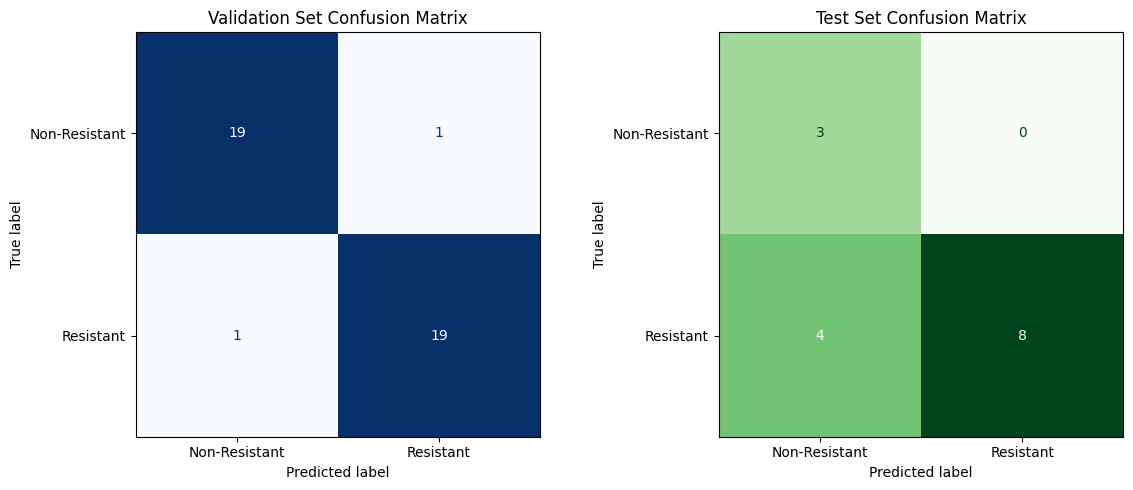

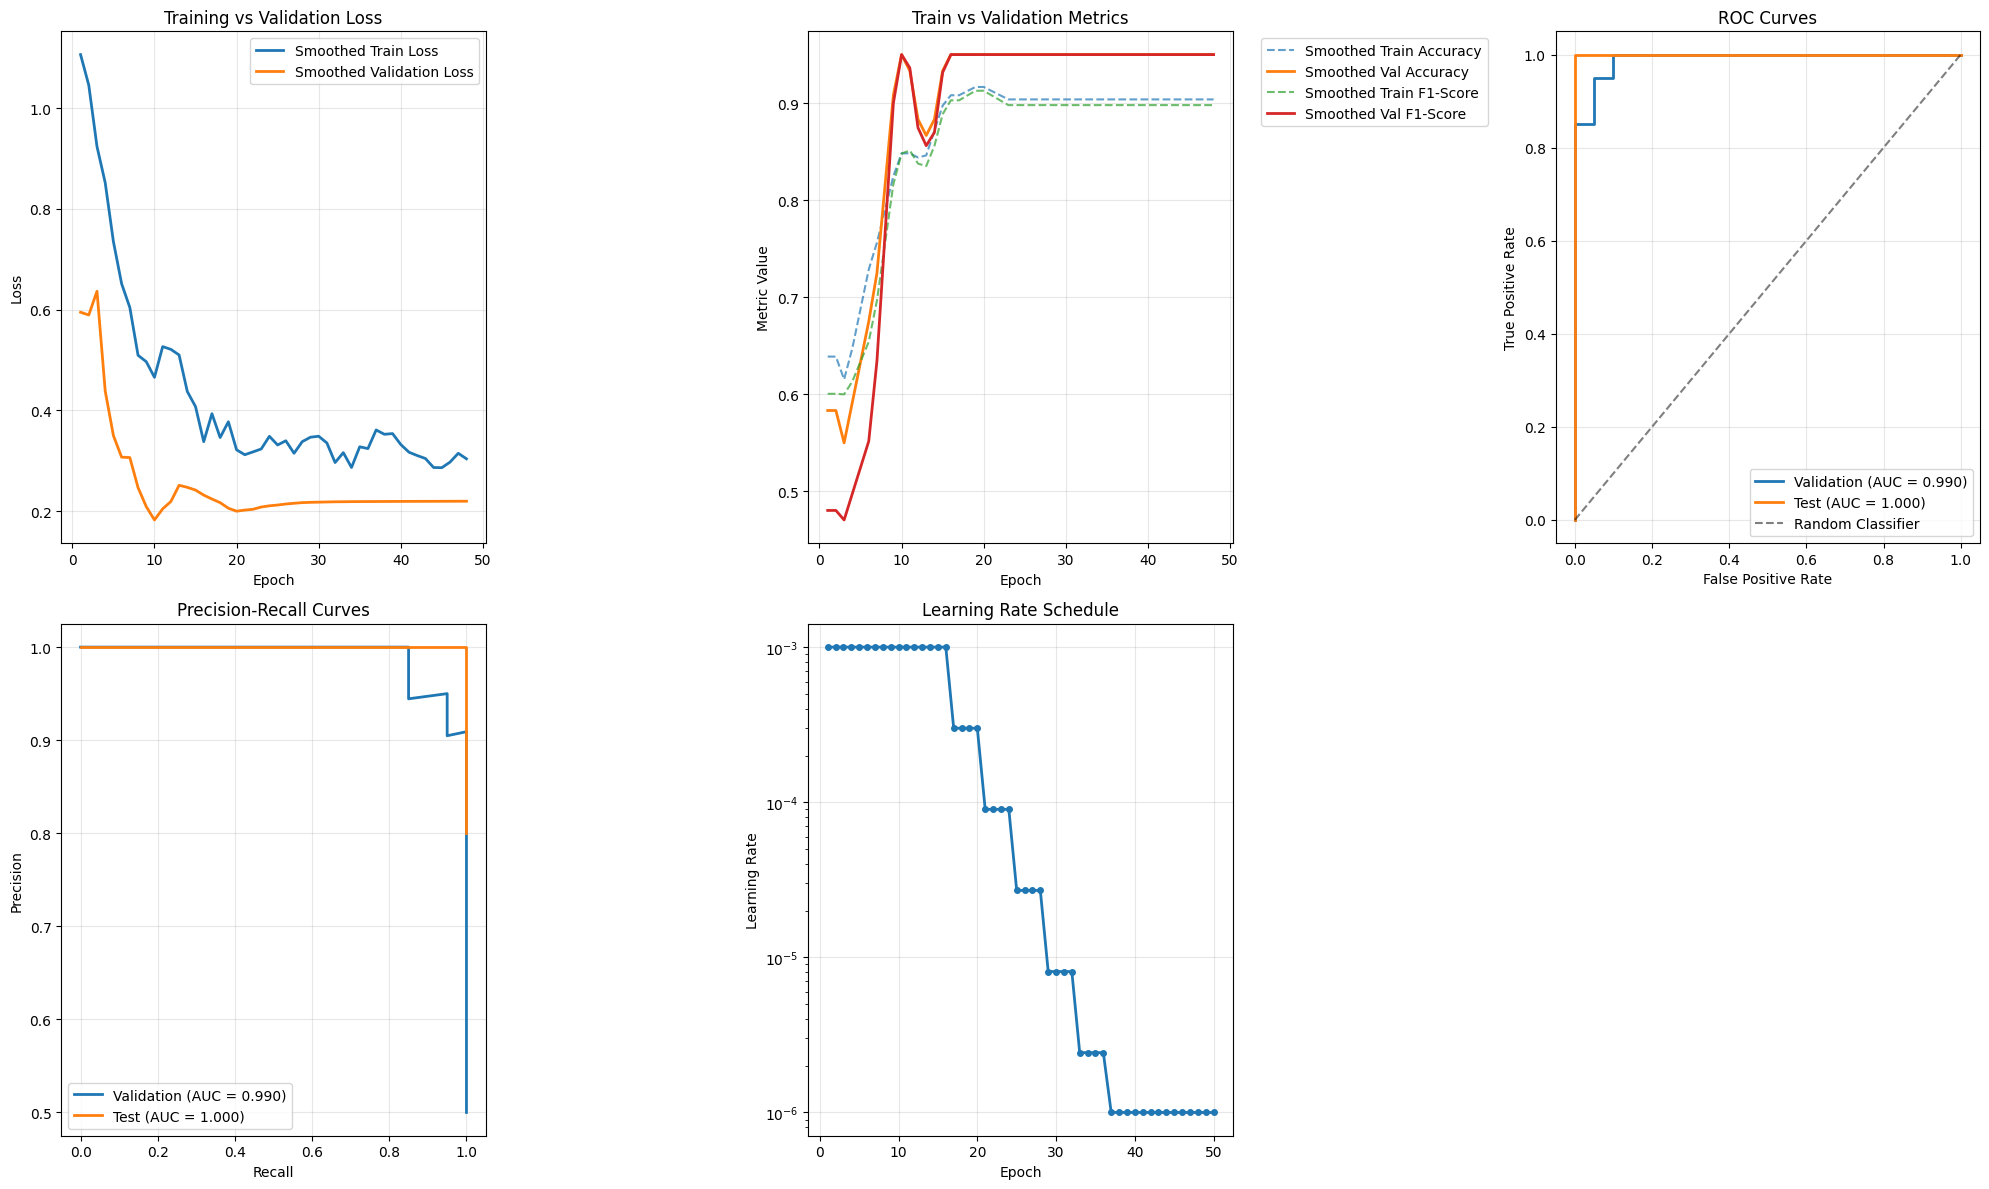

<Figure size 640x480 with 0 Axes>


PERFORMANCE SUMMARY
VALIDATION PERFORMANCE (during training):
Best Val Accuracy:  0.9500
Best Val Precision: 0.9500
Best Val Recall:    1.0000
Best Val F1 Score:  0.9500
Best Val ROC-AUC:   0.9900

Final Val Accuracy:  0.9500
Final Val Precision: 0.9500
Final Val Recall:    0.9500
Final Val F1 Score:  0.9500
Final Val ROC-AUC:   0.9900

TEST PERFORMANCE (final evaluation):
Test Accuracy:  0.7333
Test Precision: 1.0000
Test Recall:    0.6667
Test F1 Score:  0.8000
Test ROC-AUC:   1.0000

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.43      1.00      0.60         3
     Class 1       1.00      0.67      0.80        12

    accuracy                           0.73        15
   macro avg       0.71      0.83      0.70        15
weighted avg       0.89      0.73      0.76        15



In [19]:
# Define a Smoothing Function
def moving_average(values, window_size=3):
    if len(values) < window_size:
        return values
    return [sum(values[i:i+window_size]) / window_size for i in range(len(values) - window_size + 1)]

# Smooth the losses
window_size = 3
smoothed_train = moving_average(history_custom["train_loss"], window_size)
smoothed_val = moving_average(history_custom["val_loss"], window_size)
epochs_smoothed = list(range(1, len(smoothed_train) + 1))
epochs = range(1, len(history_custom["train_loss"]) + 1)

# Create a comprehensive visualization with 6 subplots
fig = plt.figure(figsize=(20, 12))

# 1. Loss curves (train vs validation)
plt.subplot(2, 3, 1)
# fig, axes = plt.subplots(1, 2, figsize=(15, 5))
# plt.plot(epochs, history["train_loss"], label="Train Loss", marker='o')
# plt.plot(epochs, history["val_loss"], label="Validation Loss", marker='s')
plt.plot(epochs_smoothed, smoothed_train, label="Smoothed Train Loss", linewidth=2)
plt.plot(epochs_smoothed, smoothed_val, label="Smoothed Validation Loss", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Performance metrics comparison (Train vs Validation)
plt.subplot(2, 3, 2)
# metrics = ['accuracy', 'precision', 'recall', 'f1']
# metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

metrics = ['accuracy', 'f1']
metric_names = ['Accuracy', 'F1-Score']

for i, metric in enumerate(metrics):
    smoothed_train_metric = moving_average(history_custom[f"train_{metric}"], window_size)
    smoothed_val_metric = moving_average(history_custom[f"val_{metric}"], window_size)
    epochs_smoothed = list(range(1, len(smoothed_train_metric) + 1))
    plt.plot(epochs_smoothed, smoothed_train_metric, label=f"Smoothed Train {metric_names[i]}", linestyle='--', alpha=0.7)
    plt.plot(epochs_smoothed, smoothed_val_metric, label=f"Smoothed Val {metric_names[i]}", linewidth=2)

plt.xlabel("Epoch")
plt.ylabel("Metric Value")
plt.title("Train vs Validation Metrics")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# 3. ROC Curves
plt.subplot(2, 3, 3)
# Validation ROC
val_fpr, val_tpr, _ = roc_curve(val_targets_probs, val_probs)
val_auc_score = auc(val_fpr, val_tpr)

# Test ROC
test_fpr, test_tpr, _ = roc_curve(test_targets_probs, test_probs)
test_auc_score = auc(test_fpr, test_tpr)

plt.plot(val_fpr, val_tpr, label=f'Validation (AUC = {val_auc_score:.3f})', linewidth=2)
plt.plot(test_fpr, test_tpr, label=f'Test (AUC = {test_auc_score:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.grid(True, alpha=0.3)

# 4. Precision-Recall Curves
plt.subplot(2, 3, 4)
# Validation PR
val_precision_curve, val_recall_curve, _ = precision_recall_curve(val_targets_probs, val_probs)
val_pr_auc = auc(val_recall_curve, val_precision_curve)

# Test PR
test_precision_curve, test_recall_curve, _ = precision_recall_curve(test_targets_probs, test_probs)
test_pr_auc = auc(test_recall_curve, test_precision_curve)

plt.plot(val_recall_curve, val_precision_curve, label=f'Validation (AUC = {val_pr_auc:.3f})', linewidth=2)
plt.plot(test_recall_curve, test_precision_curve, label=f'Test (AUC = {test_pr_auc:.3f})', linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend()
plt.grid(True, alpha=0.3)

# 5. Learning Rate Schedule
plt.subplot(2, 3, 5)
plt.plot(epochs, history_custom["learning_rate"], marker='o', linewidth=2, markersize=4)
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule")
plt.yscale('log')  # Log scale for better visualization
plt.grid(True, alpha=0.3)


# 6. Confusion Matrices (Validation and Test side by side)
plt.subplot(2, 3, 6)
# Create confusion matrices
cm_val = confusion_matrix(val_targets_final, val_preds_final)
cm_test = confusion_matrix(test_targets, test_preds)

# Create a combined visualization for confusion matrices
fig_cm, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Validation confusion matrix
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=["Non-Resistant", "Resistant"])
disp_val.plot(ax=ax1, cmap="Blues", colorbar=False)
ax1.set_title("Validation Set Confusion Matrix")

# Test confusion matrix
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=["Non-Resistant", "Resistant"])
disp_test.plot(ax=ax2, cmap="Greens", colorbar=False)
ax2.set_title("Test Set Confusion Matrix")

plt.tight_layout()

# Show the main figure (without confusion matrices)
plt.figure(fig.number)
plt.delaxes(plt.subplot(2, 3, 6))  # Remove the 6th subplot since we're showing confusion matrices separately
plt.tight_layout()
plt.show()

# Show confusion matrices separately
plt.figure(fig_cm.number)
plt.show()

# Performance Summary (keep existing summary code)
print("\nPERFORMANCE SUMMARY")
print("=" * 50)
print("VALIDATION PERFORMANCE (during training):")
print(f"Best Val Accuracy:  {max(history_custom['val_accuracy']):.4f}")
print(f"Best Val Precision: {max(history_custom['val_precision']):.4f}")
print(f"Best Val Recall:    {max(history_custom['val_recall']):.4f}")
print(f"Best Val F1 Score:  {max(history_custom['val_f1']):.4f}")
print(f"Best Val ROC-AUC:   {max(history_custom['val_roc_auc']):.4f}")

print(f"\nFinal Val Accuracy:  {history_custom['val_accuracy'][-1]:.4f}")
print(f"Final Val Precision: {history_custom['val_precision'][-1]:.4f}")
print(f"Final Val Recall:    {history_custom['val_recall'][-1]:.4f}")
print(f"Final Val F1 Score:  {history_custom['val_f1'][-1]:.4f}")
print(f"Final Val ROC-AUC:   {history_custom['val_roc_auc'][-1]:.4f}")

print("\n" + "="*50)
print("TEST PERFORMANCE (final evaluation):")
print(f"Test Accuracy:  {test_acc:.4f}")
print(f"Test Precision: {test_prec:.4f}")
print(f"Test Recall:    {test_rec:.4f}")
print(f"Test F1 Score:  {test_f1:.4f}")
print(f"Test ROC-AUC:   {test_roc_auc:.4f}")

print("\nClassification Report:")
print(classification_report(test_targets, test_preds, target_names=['Class 0', 'Class 1']))